In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv


# Train code 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 Accuracy: 0.9533333333333334

 Confusion Matrix:
 [[500   0]
 [ 28  72]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       500
           1       1.00      0.72      0.84       100

    accuracy                           0.95       600
   macro avg       0.97      0.86      0.90       600
weighted avg       0.96      0.95      0.95       600



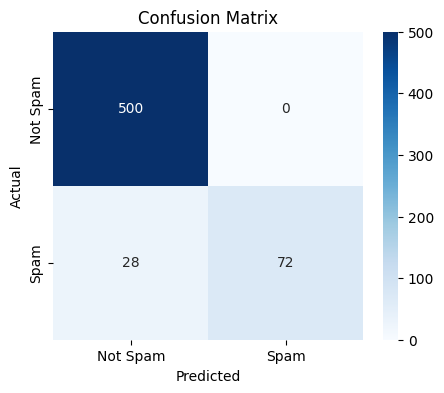

 - spam_model.pkl
 - tfidf_vectorizer.pkl
('Not Spam ', np.float64(0.549))


In [2]:

import pandas as pd
import numpy as np
import string
import nltk
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


nltk.download("stopwords")


data = pd.read_csv(
    "/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv"
)


data = data[["email", "label"]]


data["email"] = data["email"].fillna("")


def preprocess(text):
    text = text.lower()
    text = "".join(c for c in text if c not in string.punctuation)
    words = text.split()
    words = [w for w in words if w not in stopwords.words("english")]
    return " ".join(words)

data["email_clean"] = data["email"].apply(preprocess)


X = data["email_clean"]
y = data["label"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


model = LogisticRegression(max_iter=3000)
model.fit(X_train_tfidf, y_train)


y_pred = model.predict(X_test_tfidf)

print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))


plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt="d",
    cmap="Blues",
    xticklabels=["Not Spam", "Spam"],
    yticklabels=["Not Spam", "Spam"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


with open("/kaggle/working/spam_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("/kaggle/working/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)


print(" - spam_model.pkl")
print(" - tfidf_vectorizer.pkl")


model = joblib.load("/kaggle/working/spam_model.pkl")
vectorizer = joblib.load("/kaggle/working/tfidf_vectorizer.pkl")


def predict_spam(text):
    vec = vectorizer.transform([text])
    pred = model.predict(vec)[0]
    prob = model.predict_proba(vec)[0][pred]
    label = "Spam " if pred == 1 else "Not Spam "
    return label, round(prob, 3)



print(predict_spam("Congratulations! You won $1000. Click now!"))

# Visualization

/tmp/ipykernel_17/2999517420.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


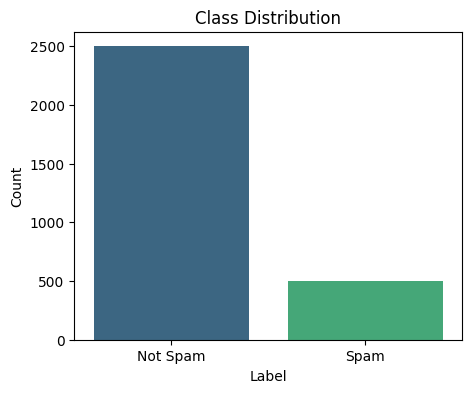

In [3]:
plt.figure(figsize=(5,4))
sns.countplot(x=y, palette="viridis")
plt.xticks([0,1], ["Not Spam", "Spam"])
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

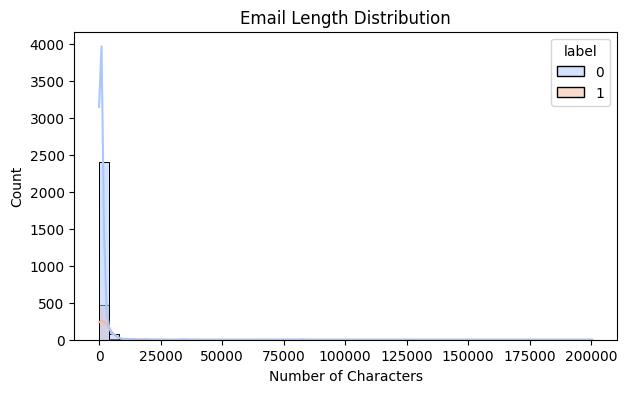

In [4]:
data["email_length"] = data["email"].apply(len)

plt.figure(figsize=(7,4))
sns.histplot(
    data=data,
    x="email_length",
    hue="label",
    bins=50,
    kde=True,
    palette="coolwarm"
)
plt.title("Email Length Distribution")
plt.xlabel("Number of Characters")
plt.show()

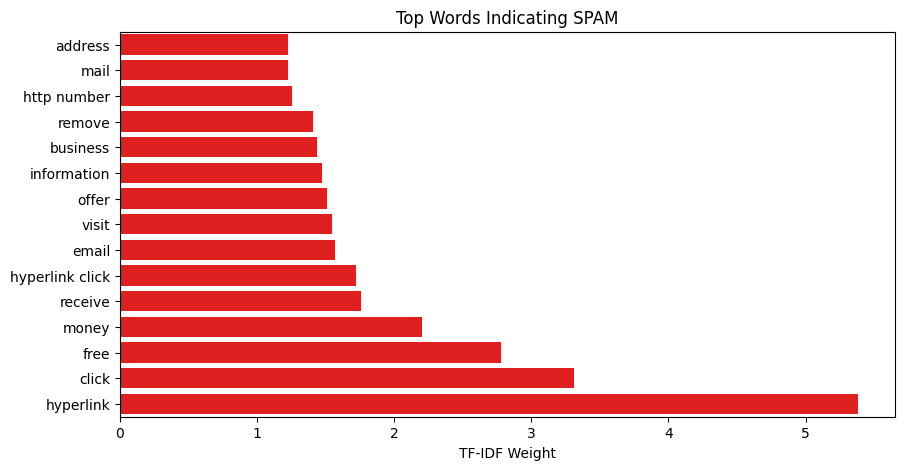

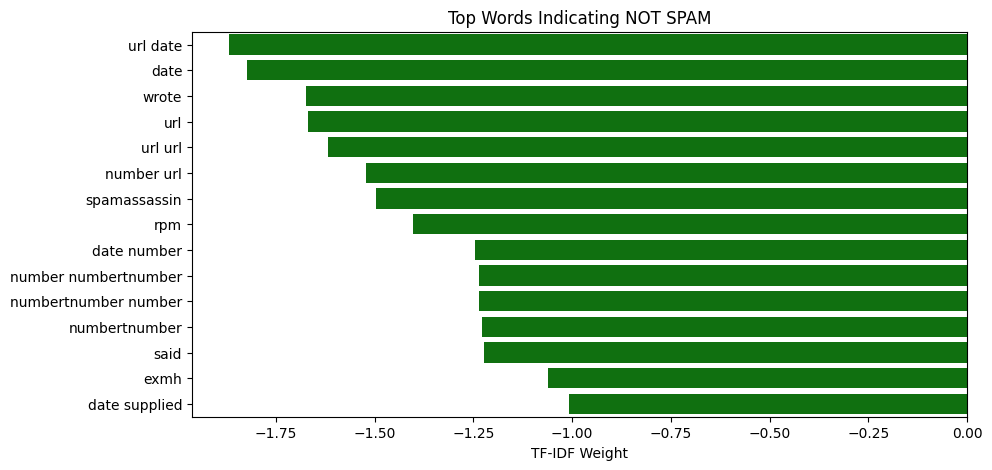

In [5]:
feature_names = np.array(tfidf.get_feature_names_out())
coefficients = model.coef_[0]

top_spam = feature_names[np.argsort(coefficients)[-15:]]
top_ham  = feature_names[np.argsort(coefficients)[:15]]

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=coefficients[np.argsort(coefficients)[-15:]],
            y=top_spam,
            color="red")
plt.title("Top Words Indicating SPAM")
plt.xlabel("TF-IDF Weight")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=coefficients[np.argsort(coefficients)[:15]],
            y=top_ham,
            color="green")
plt.title("Top Words Indicating NOT SPAM")
plt.xlabel("TF-IDF Weight")
plt.show()

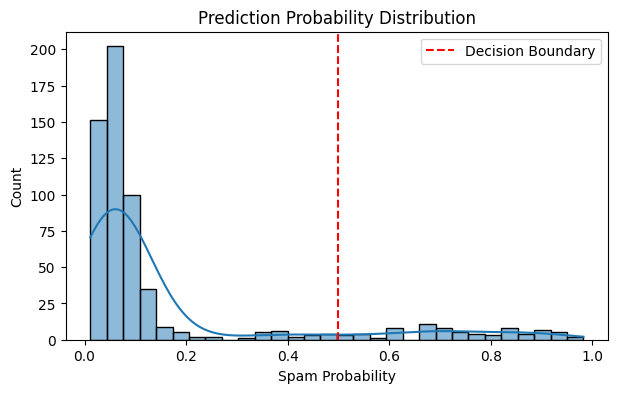

In [6]:
y_probs = model.predict_proba(X_test_tfidf)[:,1]

plt.figure(figsize=(7,4))
sns.histplot(y_probs, bins=30, kde=True)
plt.axvline(0.5, color="red", linestyle="--", label="Decision Boundary")
plt.title("Prediction Probability Distribution")
plt.xlabel("Spam Probability")
plt.legend()
plt.show()

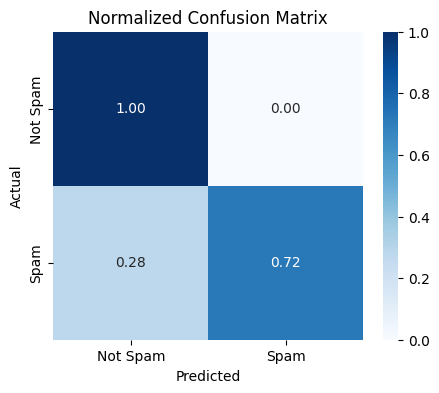

In [7]:
cm = confusion_matrix(y_test, y_pred, normalize="true")

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Not Spam", "Spam"],
            yticklabels=["Not Spam", "Spam"])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


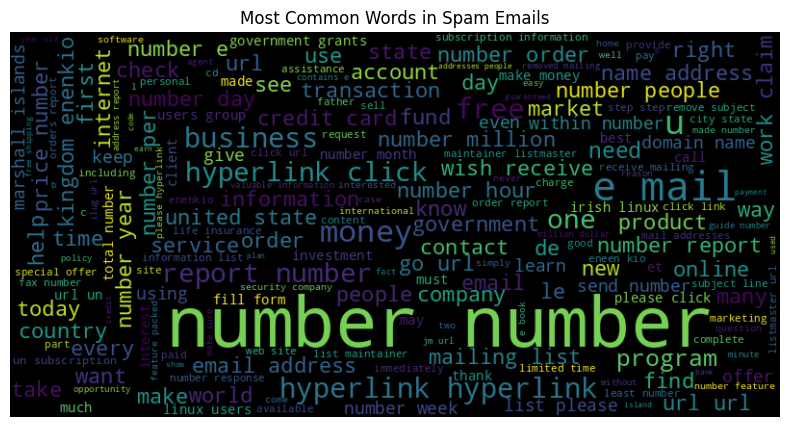

In [8]:
from wordcloud import WordCloud

spam_words = " ".join(data[data["label"]==1]["email_clean"])

wc = WordCloud(width=800, height=400, background_color="black").generate(spam_words)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Spam Emails")
plt.show()